In [68]:
import numpy as np 
import tensorflow as tf 
import tensorflow_probability as tfp
from tensorflow import keras

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%tensorflow_version 2.x

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# MNIST dataset

In [33]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

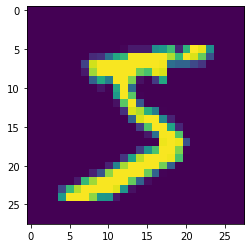

In [34]:
plt.imshow(x_train[0])

# Simple Deterministic MNIST Model

In [35]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(1280, activation="relu"),
  tf.keras.layers.Dense(1280, activation="relu"),
  tf.keras.layers.Dense(10),
])

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [37]:
model.fit(x_train, y_train,epochs=6,validation_data=(x_test, y_test))

Epoch 1/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2918 - sparse_categorical_accuracy: 0.9089 - val_loss: 0.1122 - val_sparse_categorical_accuracy: 0.9647
Epoch 2/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.0959 - val_sparse_categorical_accuracy: 0.9711
Epoch 3/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0591 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.0813 - val_sparse_categorical_accuracy: 0.9774
Epoch 4/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0442 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.0834 - val_sparse_categorical_accuracy: 0.9762
Epoch 5/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0347 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.0985 - val_sparse_categorical_accuracy: 0.9744
Epoch 6/6
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0281 - sparse_cate

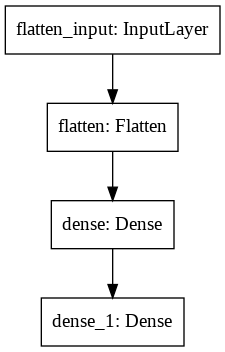

In [8]:
tf.keras.utils.plot_model(model)

In [39]:
results = model(x_test)

In [40]:
results[:20].numpy().argmax(axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

In [41]:
y_test[:20]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
      dtype=uint8)

# Variational Autoencoder

In [76]:
# Some general information on the data
input_shape = (28, 28, 1)
encoded_size = 16
base_depth = 32


In [77]:
# This is the prior on the latent space (which we assumed to be 16-dimensional)
prior = tfp.distributions.Independent(
    tfp.distributions.Normal(
        loc=tf.zeros(encoded_size),
        scale=1.0,
    ),
    reinterpreted_batch_ndims=1,
)

In [78]:
# Explore the prior
print(prior)
prior.sample(1)

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[16], dtype=float32)


<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.75226706,  0.5912186 , -1.4287255 , -1.3779198 ,  0.38388014,
         0.68339753, -0.4271518 , -1.0553145 ,  0.01436165, -0.9232181 ,
         0.85849905,  0.24240944, -0.12821557, -1.5683317 , -0.08873583,
        -0.81129414]], dtype=float32)>

In [87]:
# Define the encoder and decoder network (note that the last two
# layers are probabilistic and have to use the reparametrization trick,
# which is automatically done by tfp)
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Lambda(lambda x : tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.Conv2D(
        filters=base_depth,
        kernel_size=5,
        strides=1,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2D(
        filters=base_depth,
        kernel_size=5,
        strides=2,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2D(
        filters=2*base_depth,
        kernel_size=5,
        strides=1,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2D(
        filters=2*base_depth,
        kernel_size=5,
        strides=2,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2D(
        filters=4*encoded_size,
        kernel_size=7,
        strides=1,
        padding="valid",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(encoded_size),
        activation=None,
    ),
    tfp.layers.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior),
    )
])

In [88]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[encoded_size]),
    tf.keras.layers.Reshape([1, 1, encoded_size]),
    tf.keras.layers.Conv2DTranspose(
        filters=2*base_depth,
        kernel_size=7,
        strides=1,
        padding="valid",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=2*base_depth,
        kernel_size=5,
        strides=1,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=2*base_depth,
        kernel_size=5,
        strides=2,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=base_depth,
        kernel_size=5,
        strides=1,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=base_depth,
        kernel_size=5,
        strides=2,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=base_depth,
        kernel_size=5,
        strides=1,
        padding="same",
        activation=tf.nn.leaky_relu,
    ),
    tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=5,
        strides=1,
        padding="same",
        activation=None,
    ),
    tf.keras.layers.Flatten(),
    tfp.layers.IndependentBernoulli(
        input_shape,
        tfp.distributions.Bernoulli.logits
    )
])

In [89]:
vae = tf.keras.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

In [91]:
# Train the model (with variational inference)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(1.0e-3), loss=neg_log_likelihood)


In [93]:
import tensorflow_datasets as tfds

datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))




local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [94]:
datasets_info.features["image"].shape

(28, 28, 1)

In [95]:

_ = vae.fit(train_dataset,
            epochs=15,
            validation_data=eval_dataset)


Epoch 1/15
235/235 [==============================] - 20s 36ms/step - loss: 339.9972 - val_loss: 169.9743
Epoch 2/15
235/235 [==============================] - 10s 32ms/step - loss: 161.7478 - val_loss: 146.7233
Epoch 3/15
235/235 [==============================] - 10s 32ms/step - loss: 144.6414 - val_loss: 138.4157
Epoch 4/15
235/235 [==============================] - 10s 32ms/step - loss: 137.1652 - val_loss: 133.1993
Epoch 5/15
235/235 [==============================] - 10s 32ms/step - loss: 132.9518 - val_loss: 130.6818
Epoch 6/15
235/235 [==============================] - 10s 32ms/step - loss: 129.9687 - val_loss: 127.0028
Epoch 7/15
235/235 [==============================] - 10s 32ms/step - loss: 126.6287 - val_loss: 125.3016
Epoch 8/15
235/235 [==============================] - 10s 32ms/step - loss: 124.8317 - val_loss: 123.2653
Epoch 9/15
235/235 [==============================] - 10s 32ms/step - loss: 123.2490 - val_loss: 121.9037
Epoch 10/15
235/235 [=========================

In [132]:
def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()


In [135]:
img = next(iter(train_dataset))[0][:10]

True image


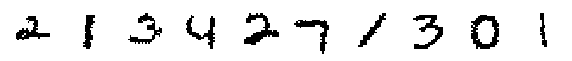

In [136]:
print("True image")
display_imgs(img)

In [137]:
re_encoded_img_dist = vae(img)

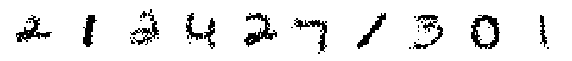

In [138]:
display_imgs(re_encoded_img_dist.sample())

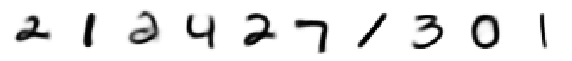

In [140]:
display_imgs(re_encoded_img_dist.mean())

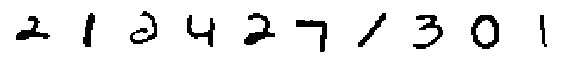

In [139]:
display_imgs(re_encoded_img_dist.mode())

In [141]:
# Generate new samples
z = prior.sample(10)
z

<tf.Tensor: shape=(10, 16), dtype=float32, numpy=
array([[-5.11918545e-01,  2.38636300e-01, -3.68483841e-01,
        -1.92138517e+00,  8.16529155e-01, -1.05571938e+00,
         2.37051725e-01, -4.82073873e-01, -1.58135191e-01,
        -1.25898218e+00,  8.96905243e-01,  1.29426312e+00,
        -7.14863122e-01,  2.56427526e-01, -4.92116302e-01,
        -2.42810976e-02],
       [ 7.77179062e-01, -5.42823136e-01, -1.17425871e+00,
         5.09026423e-02,  2.10804701e-01, -1.97151840e+00,
        -5.71465539e-03, -6.54206157e-01,  8.92045319e-01,
        -9.88766789e-01,  1.02725327e-01,  5.90835750e-01,
         1.79323339e+00, -1.14591825e+00, -4.85127062e-01,
        -1.11413574e+00],
       [-7.13919401e-01, -5.12303650e-01,  1.29846662e-01,
        -2.92243689e-01,  1.42712712e-01, -1.49346840e+00,
         8.51890147e-01, -5.15852749e-01, -9.65678170e-02,
         8.11934233e-01, -2.23061308e-01,  3.65157664e-01,
         1.89724788e-01,  7.05180705e-01,  1.90718126e+00,
        -6.80

In [143]:
x_tilde = decoder(z)

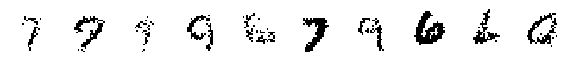

In [144]:
display_imgs(x_tilde.sample())

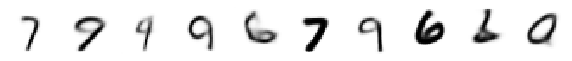

In [145]:
display_imgs(x_tilde.mean())

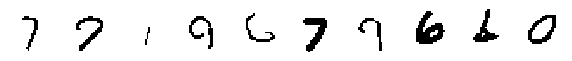

In [146]:
display_imgs(x_tilde.mode())